In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as np
from jax import grad

In [4]:
f = lambda x : np.exp(x)
g = lambda x : np.square(x)
print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0

2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers
import matplotlib.pyplot as plt # visualization

In [9]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
rng = random.PRNGKey(0)
in_shape = (-1, 1,)
out_shape, net_params = net_init(rng, in_shape)

In [11]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

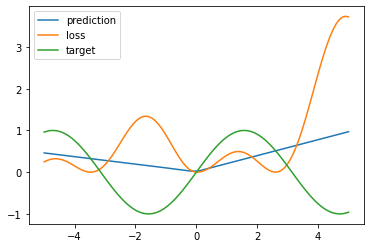

In [12]:
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [15]:
from tqdm.notebook import tqdm
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

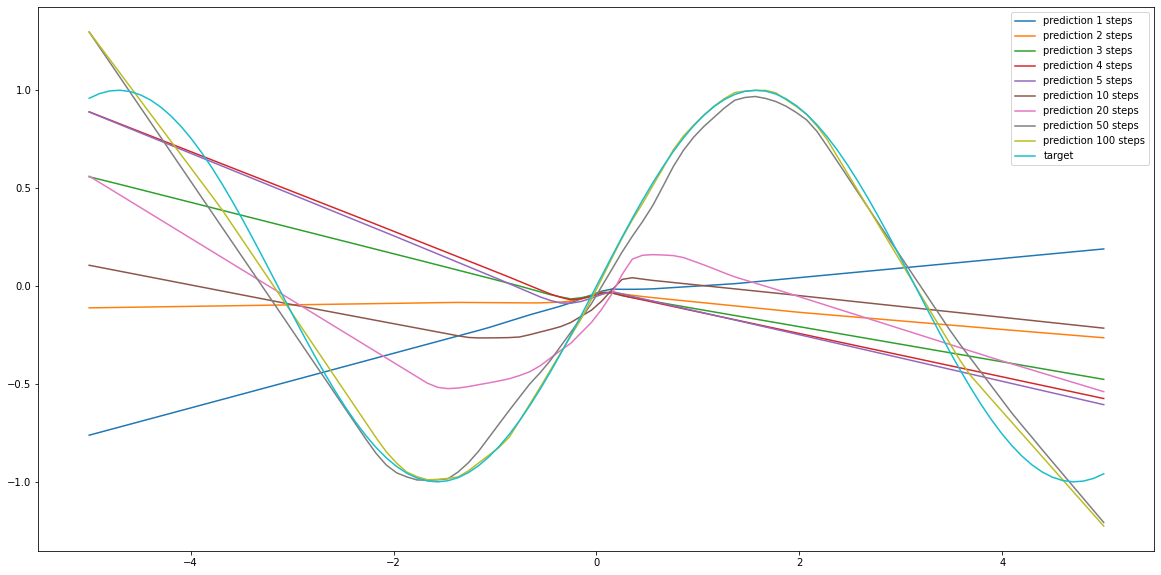

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
rng = random.PRNGKey(0)
for num_steps in tqdm([1, 2, 3, 4, 5, 10, 20, 50, 100]):
    
    net_init, net_apply = stax.serial(
        Dense(40), Relu,
        Dense(40), Relu,
        Dense(1)
    )
    
    in_shape = (-1, 1,)
    out_shape, net_params = net_init(rng, in_shape)
    
    def loss(params, inputs, targets):
        # Computes average loss for the batch
        predictions = net_apply(params, inputs)
        return np.mean((targets - predictions)**2)
    
    opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
    opt_state = opt_init(net_params)
    
    # Define a compiled update step
    @jit
    def step(i, opt_state, x1, y1):
        p = get_params(opt_state)
        g = grad(loss)(p, x1, y1)
        return opt_update(i, g, opt_state)
    
    for i in range(num_steps):
        opt_state = step(i, opt_state, xrange_inputs, targets)
    net_params = get_params(opt_state)

    # batch the inference across K=100
    targets = np.sin(xrange_inputs)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
    ax.plot(xrange_inputs, predictions, label='prediction %d steps' % num_steps)
    # plt.plot(xrange_inputs, losses, label='loss')

ax.plot(xrange_inputs, targets, label='target')
ax.legend()
plt.show()


In [22]:
g = lambda x, y : np.square(x) + y
x0 = 2.
y0 = 1.

print('grad(g)(x0) = {}'.format(grad(g)(x0, y0)))

grad(g)(x0) = 4.0


In [29]:
alpha = .1
def inner_update(p, x1, y1):
    grads = grad(loss)(p, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [30]:
x1 = xrange_inputs
y1 = targets
x2 = np.array([0.])
y2 = np.array([0.])
maml_loss(net_params, x1, y1, x2, y2)

DeviceArray(0.00022761, dtype=float32)

In [44]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)  # this LR seems to be better than 1e-2 and 1e-4
out_shape, net_params = net_init(rng, in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1, x2, y2):
    p = get_params(opt_state)
    g = grad(maml_loss)(p, x1, y1, x2, y2)
    l = maml_loss(p, x1, y1, x2, y2)
    return opt_update(i, g, opt_state), l
K=20

np_maml_loss = []

# Adam optimization
n_steps = 20000
pbar = tqdm(range(n_steps))
# for i in range(20000):
for i in pbar:
    # define the task
    A = onp.random.uniform(low=0.1, high=.5)
    phase = onp.random.uniform(low=0., high=np.pi)
    # meta-training inner split (K examples)
    x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
    y1 = A * onp.sin(x1 + phase)
    # meta-training outer split (1 example). Like cross-validating with respect to one example.
    x2 = onp.random.uniform(low=-5., high=5.)
    y2 = A * onp.sin(x2 + phase)
    opt_state, l = step(i, opt_state, x1, y1, x2, y2)
    np_maml_loss.append(l)
    # if i % 1000 == 0:
    #     print(i)
    
    pbar.set_postfix(loss=l)
    
net_params = get_params(opt_state)

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x12aa9dad0>
Traceback (most recent call last):
KeyboardInterrupt: 


KeyboardInterrupt: 

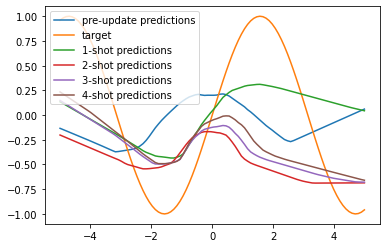

In [42]:
# batch the inference across K=100
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
plt.plot(xrange_inputs, predictions, label='pre-update predictions')
plt.plot(xrange_inputs, targets, label='target')

x1 = onp.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * onp.sin(x1 + 0.)

for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
    plt.plot(xrange_inputs, predictions, label='{}-shot predictions'.format(i))
plt.legend()